In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import pystan
import pandas as pd
import math
import datetime
from sklearn.metrics import mean_squared_error
import pandas
import seaborn


In [2]:
dta = pd.read_csv('/content/weekly_in_situ_co2_mlo - weekly_in_situ_co2_mlo.csv')


In [3]:
dta.head()

,Date,Amp
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


In [4]:
dta['Date'] = pd.to_datetime(dta['Date'])

In [5]:
dta['Amp']

0       316.19
1       317.31
2       317.69
3       317.58
4       316.48
         ...  
3205    414.84
3206    415.46
3207    415.68
3208    416.91
3209    416.45
Name: Amp, Length: 3210, dtype: float64

In [6]:
dta.loc[2632:, ["Date"]]

,Date
2632,2010-01-02
2633,2010-01-09
2634,2010-01-16
2635,2010-01-23
2636,2010-01-30
...,...
3205,2021-01-16
3206,2021-01-23
3207,2021-01-30
3208,2021-02-06


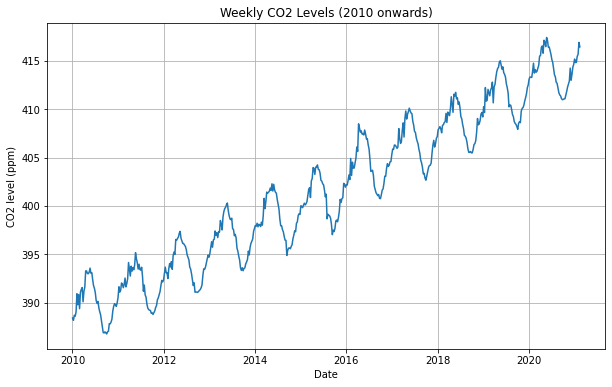

In [7]:
x = dta.loc[2632:, ["Date"]]
y = dta.loc[2632:, ['Amp']]

#Plotting figure from instructions 
fig1 = plt.figure(figsize=(10,6))
plt.plot(x,y)
plt.grid()
plt.title('Weekly CO2 Levels (2010 onwards)')
plt.xlabel("Date")
plt.ylabel('CO2 level (ppm)')
plt.show()

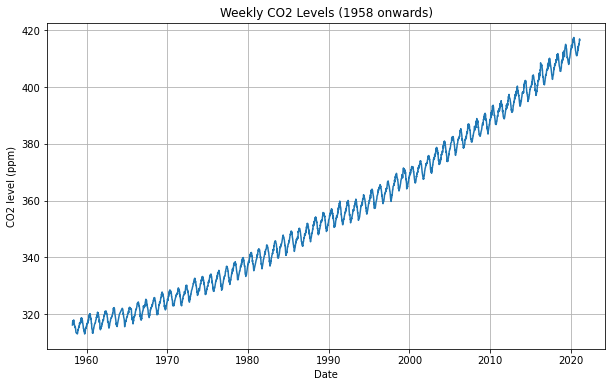

In [8]:
x1 = dta.Date
y1 = dta.Amp

#Plotting figure from instructions 
fig1 = plt.figure(figsize=(10,6))
plt.plot(x1,y1)
plt.grid()
plt.title('Weekly CO2 Levels (1958 onwards)')
plt.xlabel("Date")
plt.ylabel('CO2 level (ppm)')
plt.show()

In [9]:
# quantifying a week
(dta.Date[1] - dta.Date[0]).days / 365.25

0.019164955509924708

In [10]:
# adding a column of time translated in weeks for our Stan model
dta['Time_Progression'] = [(dta.Date[i] - dta.Date[0]).days / 365.25 for i in range(len(dta.Date))]

dta.head()


,Date,Amp,Time_Progression
0,1958-03-29,316.19,0.000000
1,1958-04-05,317.31,0.019165
2,1958-04-12,317.69,0.038330
3,1958-04-19,317.58,0.057495
4,1958-04-26,316.48,0.076660


In [11]:
dta.tail()

,Date,Amp,Time_Progression
3205,2021-01-16,414.84,62.803559
3206,2021-01-23,415.46,62.822724
3207,2021-01-30,415.68,62.841889
3208,2021-02-06,416.91,62.861054
3209,2021-02-13,416.45,62.880219


## Stan Model


In [12]:
dta.Amp.values

array([316.19, 317.31, 317.69, ..., 415.68, 416.91, 416.45])

In [13]:
stan_data = {
    "len_data" : len(dta),
    "date" : dta.Time_Progression.values,
    "ppm" : dta.Amp.values,
}

In [14]:
linear_stan_code = """
data {
    int<lower=0> len_data;             // length of data
    real<lower=0> date[len_data];      // time since beginning of study
    real ppm[len_data];               // ppm data
}

parameters {
    real<lower=0> b;  // y cut
    real<lower=0> m;  // gradient
    real<lower=0> vari;        // noise parameter in normal
} 

model {
 
    // Priors
    b ~ normal(300, 15);
    m ~ normal(0.8,1.5);
    vari ~ cauchy(10,5);

    for (i in 1:len_data) {
        ppm[i] ~ normal(m*date[i]+b, vari); 
    }
}

"""
linear = pystan.StanModel(model_code=linear_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c8dcd99c695988c6c142f9d5b4f966db NOW.


In [15]:
#Extract our results through sampling 
linear_results = linear.sampling(data=stan_data)
linear_samples = linear_results.extract()


In [16]:
result_linear = linear.sampling(data = stan_data)
print(result_linear.stansummary())

Inference for Stan model: anon_model_c8dcd99c695988c6c142f9d5b4f966db.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b    305.63  3.1e-3   0.15 305.32 305.52 305.63 305.74 305.93   2444    1.0
m      1.59  9.1e-5 4.2e-3   1.58   1.59   1.59    1.6    1.6   2061    1.0
vari   4.47  1.8e-3   0.06   4.37   4.44   4.47   4.51   4.59   1046    1.0
lp__  -6404    0.04   1.21  -6407  -6404  -6403  -6403  -6402    933    1.0

Samples were drawn using NUTS at Thu Apr 22 19:37:20 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [17]:
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))
    
def acf_plots(samples,parameters):
    for param in parameters:
        plt.figure(figsize=(10, 3))
        plot_acf(samples[param])
        plt.title('Autocorrelation of '+ str(param) +' samples')
    plt.show()

def pair_plots(samples,parameters):
    df = pd.DataFrame(
        data=np.transpose([samples[param] for param in parameters]),
        columns=parameters)
    seaborn.pairplot(df, size=3.5, plot_kws={'marker': '.', 'alpha': 0.25})
    plt.show()

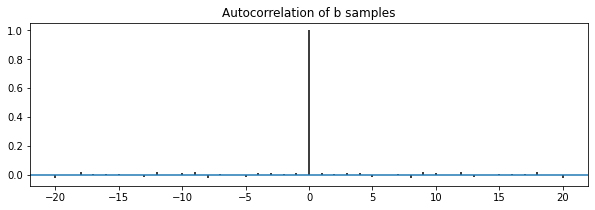

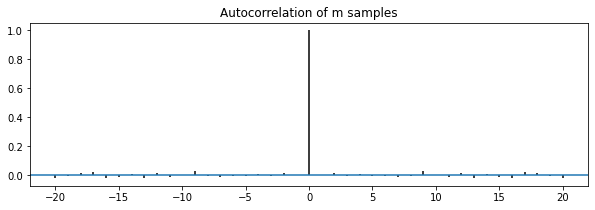

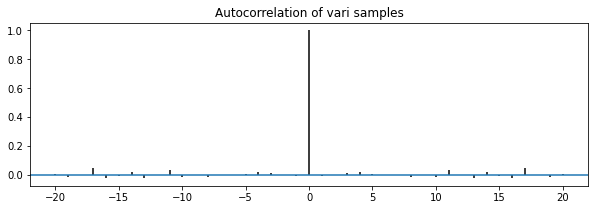

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
INFO:numexpr.utils:NumExpr defaulting to 2 threads.


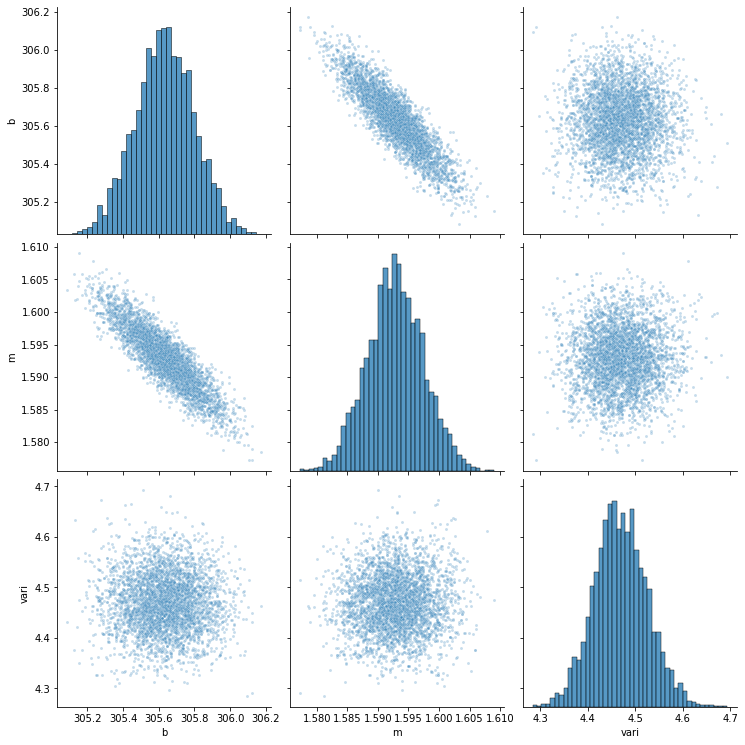

In [18]:
linear_params = ['b', 'm', 'vari']
acf_plots(linear_samples,linear_params)

pair_plots(linear_samples, linear_params)

In [19]:
# Linear line of best fit
linear_approx = linear_samples['b'].mean() + linear_samples['m'].mean()*dta.Time_Progression.values


Text(0, 0.5, 'CO$_2$ level (ppm)')

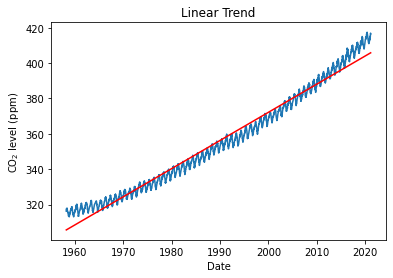

In [20]:
plt.plot(x1,y1)
plt.plot(dta.Date,linear_approx, 'Red')
plt.title('Linear Trend')
plt.xlabel("Date")
plt.ylabel(r'CO$_2$ level (ppm)')

## Quadratic Approximation

In [21]:
quadratic_stan_code = """
data {
    int<lower=0> len_data;             // length of data
    real<lower=0> date[len_data];      // time since beginning of study
    real ppm[len_data];               // ppm data
}

parameters {
    real<lower=0> c;  // y cut
    real<lower=0> a;  // ax^2
    real<lower=0> b;  // bx
    real<lower=0> vari;        // noise parameter in normal
} 

model {
 
    // Priors
    c ~ normal(300, 30);
    a ~ normal(1,1);
    b ~ normal(0,5);
    vari ~ cauchy(10,5);

    for (i in 1:len_data) {
        ppm[i] ~ normal(a*date[i]^2+b*date[i]+c, vari); 
    }
}

"""
quadratic = pystan.StanModel(model_code=quadratic_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_664f4bc0fb2d82e759d18d98b781b4b4 NOW.


In [22]:
quadratic_results = quadratic.sampling(data=stan_data)
quadratic_samples = quadratic_results.extract()

In [23]:
result_quadratic = quadratic.sampling(data = stan_data)
print(result_quadratic.stansummary())

Inference for Stan model: anon_model_664f4bc0fb2d82e759d18d98b781b4b4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c    314.69  3.2e-3   0.12 314.46 314.61 314.69 314.78 314.93   1418    1.0
a      0.01  4.0e-6 1.3e-4   0.01   0.01   0.01   0.01   0.01   1105    1.0
b      0.75  2.6e-4 8.8e-3   0.73   0.75   0.75   0.76   0.77   1099    1.0
vari   2.25  7.1e-4   0.03   2.19   2.23   2.25   2.27    2.3   1555    1.0
lp__  -4203    0.04   1.43  -4206  -4204  -4203  -4202  -4201   1203    1.0

Samples were drawn using NUTS at Thu Apr 22 19:42:36 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


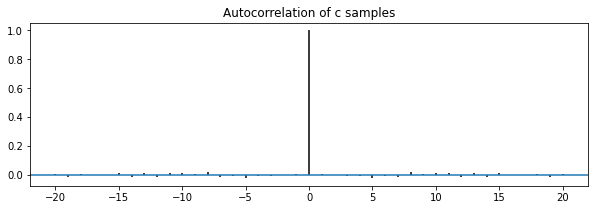

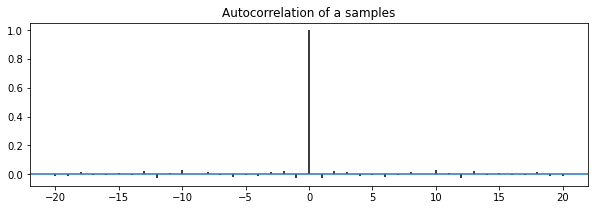

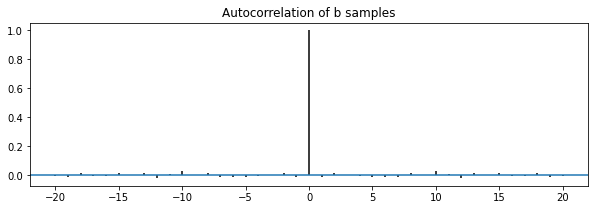

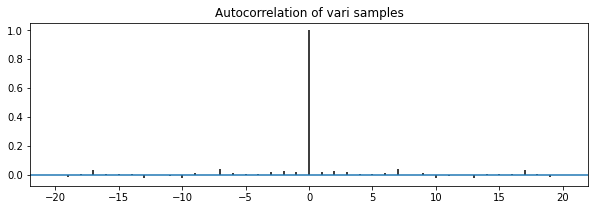

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


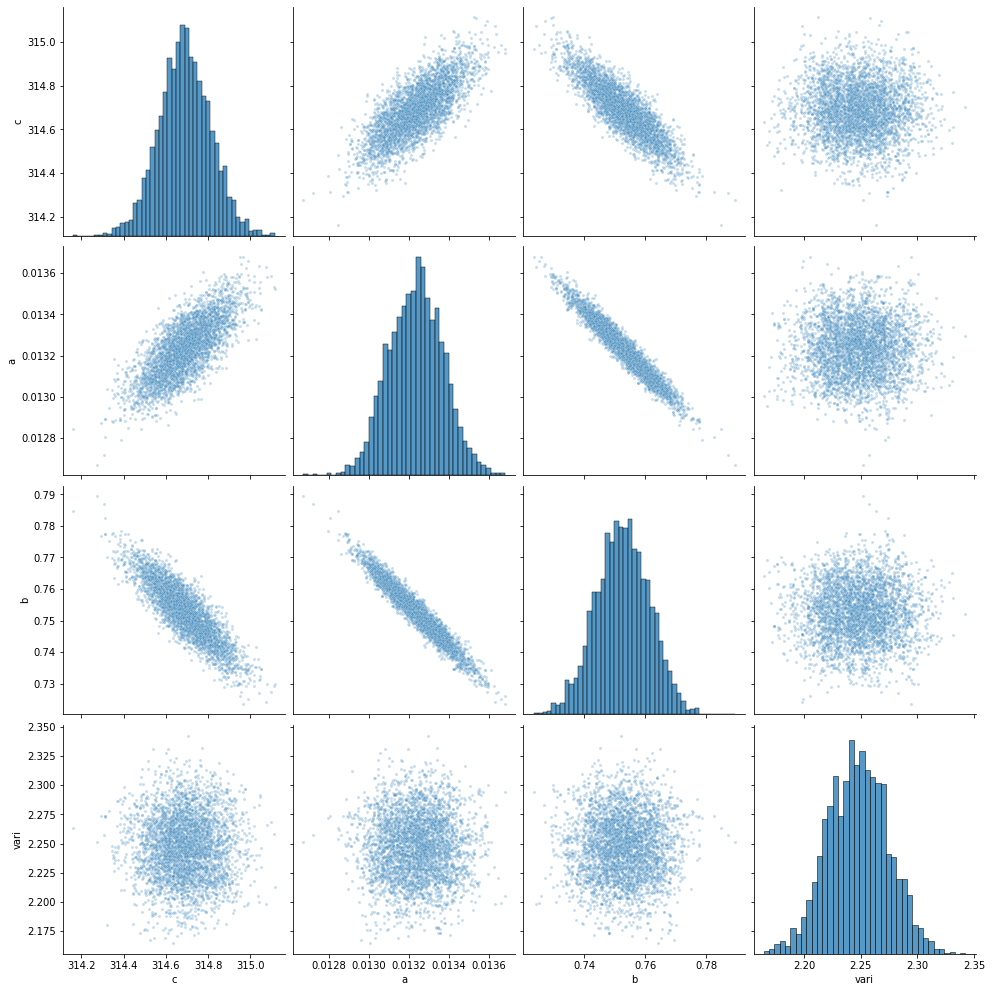

In [24]:
quadratic_params = ['c', 'a', 'b', 'vari']
acf_plots(quadratic_samples, quadratic_params)

pair_plots(quadratic_samples, quadratic_params)

In [25]:
quadratic_line = quadratic_samples['c'].mean() + quadratic_samples['b'].mean()*dta.Time_Progression.values + quadratic_samples['a'].mean()*dta.Time_Progression.values**2

Text(0, 0.5, 'CO$_2$ level (ppm)')

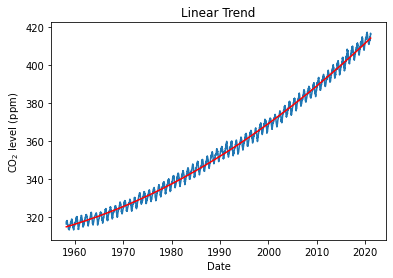

In [26]:
plt.plot(x1,y1)
plt.plot(dta.Date,quadratic_line, 'Red')
plt.title('Linear Trend')
plt.xlabel("Date")
plt.ylabel(r'CO$_2$ level (ppm)')

## Seasonal Analysis

Text(0, 0.5, 'Variation')

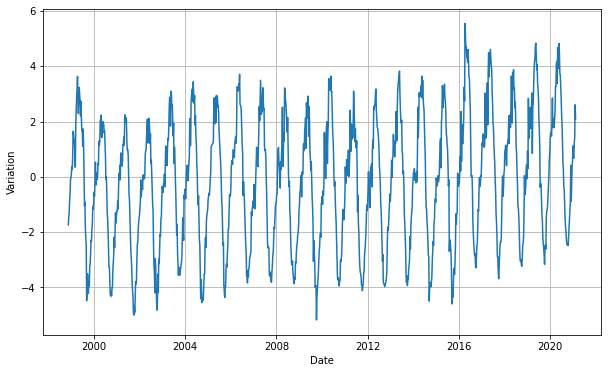

In [27]:
# First we must check the variance of the data from the approximation we did
# I chose the quadratic line since it approximated the upward curve better than the linear one

s1 = dta.Amp - quadratic_line
plt.figure(figsize = (10,6))
plt.plot(dta.Date[2061:], s1[2061:])
plt.grid()
plt.xlabel('Date')
plt.ylabel('Variation')

In [28]:
# adding a column of seasonal variation
dta['Seasonal'] = dta.Amp - quadratic_line


s1_data = {
    "len_data" : len(dta),
    "date" : dta.Time_Progression.values,
    "ppm" : dta.Seasonal.values,
    "two_pi" : 2*np.pi
}

dta['Seasonal'][20]

-1.1905790844547255

In [29]:
#co2_quadratic = """

cos_seasonal_stan_code = """
data {
    int<lower=0> len_data;             // length of data
    real<lower=0> date[len_data];      // time since beginning of study
    real ppm[len_data];               // ppm data
    real<lower=0> two_pi;
    
}

parameters {
    real<lower=0> c2;  
    real<lower=0> vari;        // noise parameter in normal

    // We need a periodic phi
    real periodic_x;
    real periodic_y;

} 

transformed parameters {
    real phi = atan2(periodic_x,periodic_y) ;
}

model {
 
    // Priors
    periodic_x ~ normal(0,0.5);
    periodic_y ~ normal(0,0.5);
    c2 ~ inv_gamma(6, 1);
    vari ~ cauchy(0,2);

    for (i in 1:len_data) {
        ppm[i] ~ normal(c2*cos(two_pi*date[i]+phi), vari); 
    }
}

"""
cos_seasonal_model = pystan.StanModel(model_code=cos_seasonal_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bea2eb13fc03ed38c96d1a0ad7e83653 NOW.


In [30]:
stan_quadratic_results = cos_seasonal_model.sampling(data=s1_data)
print(stan_quadratic_results)

Inference for Stan model: anon_model_bea2eb13fc03ed38c96d1a0ad7e83653.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c2           2.86  5.6e-4   0.02   2.81   2.84   2.86   2.87    2.9   1857    1.0
vari         0.98  3.1e-4   0.01   0.96   0.97   0.98   0.99   1.01   1552    1.0
periodic_x  -0.28  5.2e-3   0.13  -0.57  -0.36  -0.26  -0.18  -0.09    580   1.01
periodic_y   0.64    0.01   0.29   0.21   0.41    0.6   0.82   1.31    580   1.01
phi         -0.41  1.4e-4 8.7e-3  -0.43  -0.42  -0.41  -0.41  -0.39   4120    1.0
lp__        -1557    0.06   1.58  -1561  -1558  -1557  -1556  -1555    795    1.0

Samples were drawn using NUTS at Thu Apr 22 19:48:07 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [31]:
#Extract our results through sampling 
cos_seasonal = stan_quadratic_results.extract()

cos_seasonal_line = cos_seasonal['c2'].mean()*np.cos(2*np.pi*dta.Time_Progression.values+cos_seasonal['phi'].mean())
len(cos_seasonal_line)

cos_seasonal_line[2850:]

array([ 2.46165041e+00,  2.61769273e+00,  2.73582370e+00,  2.81433247e+00,
        2.85208201e+00,  2.84852561e+00,  2.80371477e+00,  2.71829848e+00,
        2.59351380e+00,  2.43116796e+00,  2.23361215e+00,  2.00370754e+00,
        1.74478377e+00,  1.46059076e+00,  1.15524440e+00,  8.33166950e-01,
        4.99022963e-01,  1.57651760e-01, -1.86002671e-01, -5.26963276e-01,
       -8.60292012e-01, -1.18116137e+00, -1.48492428e+00, -1.76718143e+00,
       -2.02384496e+00, -2.25119769e+00, -2.44594692e+00, -2.60527216e+00,
       -2.72686593e+00, -2.80896724e+00, -2.85038702e+00, -2.85052541e+00,
       -2.80938040e+00, -2.72754788e+00, -2.60621302e+00, -2.44713306e+00,
       -2.25261194e+00, -2.02546684e+00, -1.76898744e+00, -1.48688827e+00,
       -1.18325489e+00, -8.62484748e-01, -5.29223471e-01, -1.88297591e-01,
        1.55355352e-01,  4.96758326e-01,  8.30966881e-01,  1.15314077e+00,
        1.45861402e+00,  1.74296256e+00,  2.00206823e+00,  2.23217849e+00,
        2.42996070e+00,  

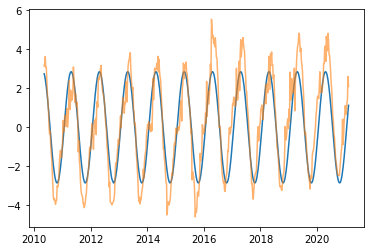

In [32]:
plt.plot(dta.Date[2650:], cos_seasonal_line[2650:])
plt.plot(dta.Date[2650:],dta.Seasonal[2650:],alpha=0.6,label="Real Data")

## Prediction Time

In [33]:
dta.tail()

,Date,Amp,Time_Progression,Seasonal
3205,2021-01-16,414.84,62.803559,0.674503
3206,2021-01-23,415.46,62.822724,1.248213
3207,2021-01-30,415.68,62.841889,1.421912
3208,2021-02-06,416.91,62.861054,2.605602
3209,2021-02-13,416.45,62.880219,2.099282


In [34]:
prediction_dates = pd.date_range("2021-02-13", "2060-01-01", freq='W-FRI')
prediction_times = (prediction_dates - dta.Date[0]).days / 365.25

In [35]:
prediction_times

Float64Index([ 62.89664613278576,  62.91581108829569,  62.93497604380561,
              62.954140999315534,  62.97330595482546, 62.992470910335385,
              63.011635865845314, 63.030800821355236,  63.04996577686516,
              63.069130732375086,
              ...
              101.57152635181383, 101.59069130732375, 101.60985626283367,
               101.6290212183436, 101.64818617385353, 101.66735112936345,
              101.68651608487338,  101.7056810403833, 101.72484599589322,
              101.74401095140315],
             dtype='float64', length=2028)

In [37]:
stan_data = {
    "len_data" : len(dta),
    "date" : dta.Time_Progression.values,
    "ppm" : dta.Amp,
    "two_pi" : 2*np.pi,
    "n_future" : len(prediction_times),
    "future_time" : prediction_times
}


In [43]:
#co2_quadratic = """

cos_predictive_stan_code = """
data {
    int<lower=0> len_data;             // length of data
    real<lower=0> date[len_data];      // time since beginning of study
    real ppm[len_data];               // ppm data
    real<lower=0> two_pi;
    
    int<lower=0> n_future; // The number of future values to predict
    real<lower=0> future_time[n_future];
}

parameters {

    real<lower=0> a;  // ax^2
    real<lower=0> b; // bx
    real<lower=0> c;  // y-int
    real<lower=0> c2;  
    real<lower=0> vari;        // noise parameter in normal

    // We need a periodic phi
    real periodic_x;
    real periodic_y;

} 

transformed parameters {
    real phi = atan2(periodic_x,periodic_y) ;
}

model {
 
    // Priors
    a ~ normal(1,1);
    b ~ normal(0,5);
    c ~ normal(300,15);

    periodic_x ~ normal(0,0.5);
    periodic_y ~ normal(0,0.5);
    c2 ~ normal(6, 1);
    vari ~ cauchy(0,2);

    for (i in 1:len_data) {
        ppm[i] ~ normal(a*date[i]^2 + b*date[i] + c+ c2*cos(two_pi*date[i]+phi), vari); 
    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_future[n_future];
    for(i in 1:n_future) {
        x_future[i] = normal_rng(
            a*future_time[i]^2+b*future_time[i]+c+c2*cos(two_pi*future_time[i]+phi), vari
            );
    }
}
"""

cos_predictive_model = pystan.StanModel(model_code=cos_predictive_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8daedcb0fe0f07c1022c6b2ac01c86a0 NOW.


In [45]:
stan_results = cos_predictive_model.sampling(data=stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [46]:
stan_results


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_8daedcb0fe0f07c1022c6b2ac01c86a0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a              0.01  1.3e-6 5.8e-5   0.01   0.01   0.01   0.01   0.01   1878    1.0
b              0.75  8.9e-5 3.8e-3   0.74   0.75   0.75   0.75   0.76   1870    1.0
c            314.72  1.2e-3   0.05 314.61 314.68 314.71 314.75 314.82   2134    1.0
c2             2.86  2.5e-3   0.03   2.81   2.84   2.86   2.88   2.91    102   1.05
vari           0.98  2.1e-3   0.01   0.95   0.97   0.98   0.99   1.01     48   1.09
periodic_x    -0.24    0.01   0.13  -0.53  -0.33  -0.23  -0.14  -0.04    130   1.04
periodic_y     0.56    0.03    0.3    0.1   0.33   0.54   0.76   1.21    130   1.04
phi           -0.41  1.4e-4 8.5e-3  -0.43  -0.42  -0.41  -0.41  -0.39   3605    1.0
x_future[1]  41

In [47]:
samples = stan_results.extract()

In [53]:
a = samples['a'].mean()
b = samples['b'].mean()
c = samples['c'].mean()
c2 = samples['c2'].mean()
phi = samples['phi'].mean()

In [66]:
predic = a*dta.Time_Progression.values**2 + b*dta.Time_Progression.values + c +c2 * np.cos((2 *np.pi *dta.Time_Progression.values)+phi)

In [67]:
predic

array([317.33501031, 317.46757657, 317.56050063, ..., 414.77508735,
       415.1565486 , 415.52631154])

Text(0.5, 1.0, 'CO2 levels from 1958')

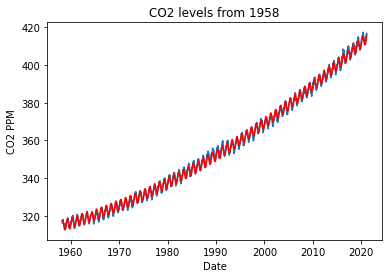

In [73]:
plt.plot(dta.Date, dta.Amp)
plt.plot(dta.Date, predic, color='red')
plt.xlabel('Date')
plt.ylabel('CO2 PPM')
plt.title('CO2 levels from 1958')


Text(0.5, 1.0, 'CO2 Levels since 2000')

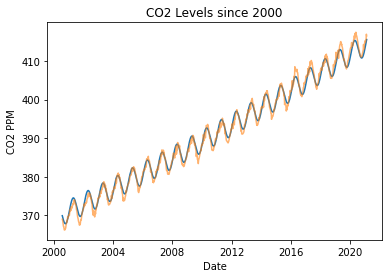

In [74]:
# lets zoom in to get a clearer view

plt.plot(dta.Date[2150:], predic[2150:])
plt.plot(dta.Date[2150:],dta.Amp[2150:],alpha=0.6,label="Real Data")
plt.xlabel('Date')
plt.ylabel('CO2 PPM')
plt.title('CO2 Levels since 2000')

In [75]:
len(predic)

3210

In [87]:
#get the mean predictions from our samples
predictions = []
for i in range(2028):
  sum1 = 0
  for j in range(1000):
    sum1+= samples['x_future'][j][i]
  predictions.append(sum1/1000)

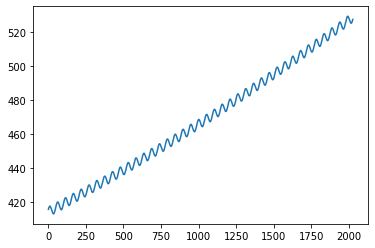

In [88]:
plt.plot(predictions)

In [89]:
lower = []
upper = []
for i in range(2028):
  store = []
  for j in range(1000):
    store.append(samples['x_future'][j][i])
  lower.append(np.percentile(store, 2.5))
  upper.append(np.percentile(store, 97.5))

In [91]:
len(prediction_dates)
len(predictions)

2028

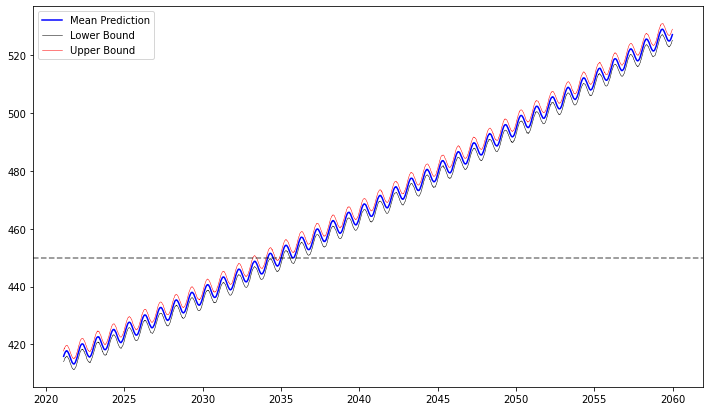

In [134]:
plt.figure(figsize=(12,7))
plt.plot(prediction_dates,predictions, color = 'blue', label = 'Mean Prediction')
plt.plot(prediction_dates,lower, color = 'black', linewidth = 0.5, label = 'Lower Bound')
plt.plot(prediction_dates, upper, color = 'red', linewidth = 0.5, label = 'Upper Bound')
plt.legend()
plt.axhline(450, color = 'black',alpha=0.5,ls='dashed')


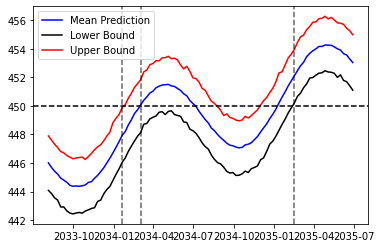

In [122]:
plt.plot(prediction_dates[650:750],predictions[650:750], color = 'blue', label = 'Mean Prediction')
plt.plot(prediction_dates[650:750],lower[650:750], color = 'black', label = 'Lower Bound')
plt.plot(prediction_dates[650:750], upper[650:750], color = 'red', label ='Upper Bound')
plt.legend()
plt.axhline(450, color = 'black', ls = 'dashed')
plt.axvline(prediction_dates[730], color = 'black', ls='dashed', alpha = 0.6)
plt.axvline(prediction_dates[680], color = 'black', ls='dashed', alpha = 0.6)
plt.axvline(prediction_dates[674], color = 'black', ls='dashed', alpha = 0.6)

In [130]:
print('The predicted date to reach 450 ppm is:',prediction_dates[680], 'with a 95% confidence interval between',prediction_dates[674],'and',prediction_dates[730])

The predicted date to reach 450 ppm is: 2034-03-03 00:00:00 with a 95% confidence interval between 2034-01-20 00:00:00 and 2035-02-16 00:00:00


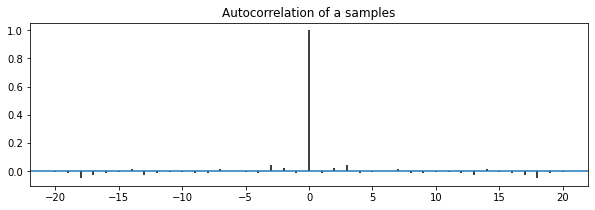

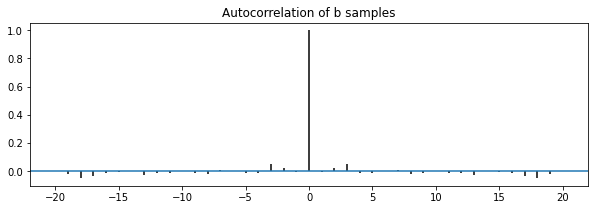

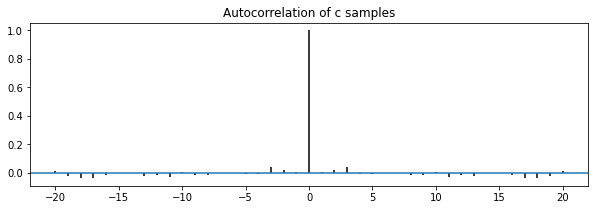

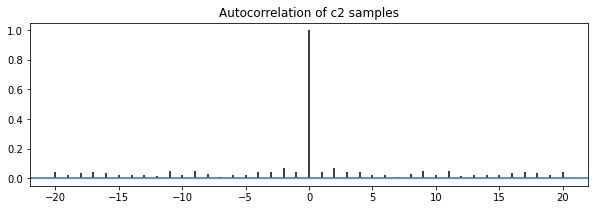

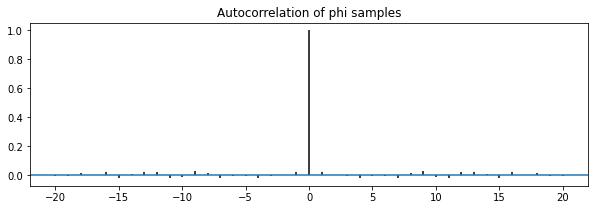

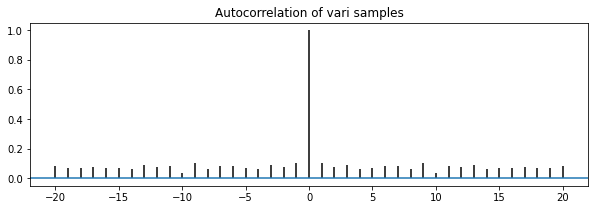

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


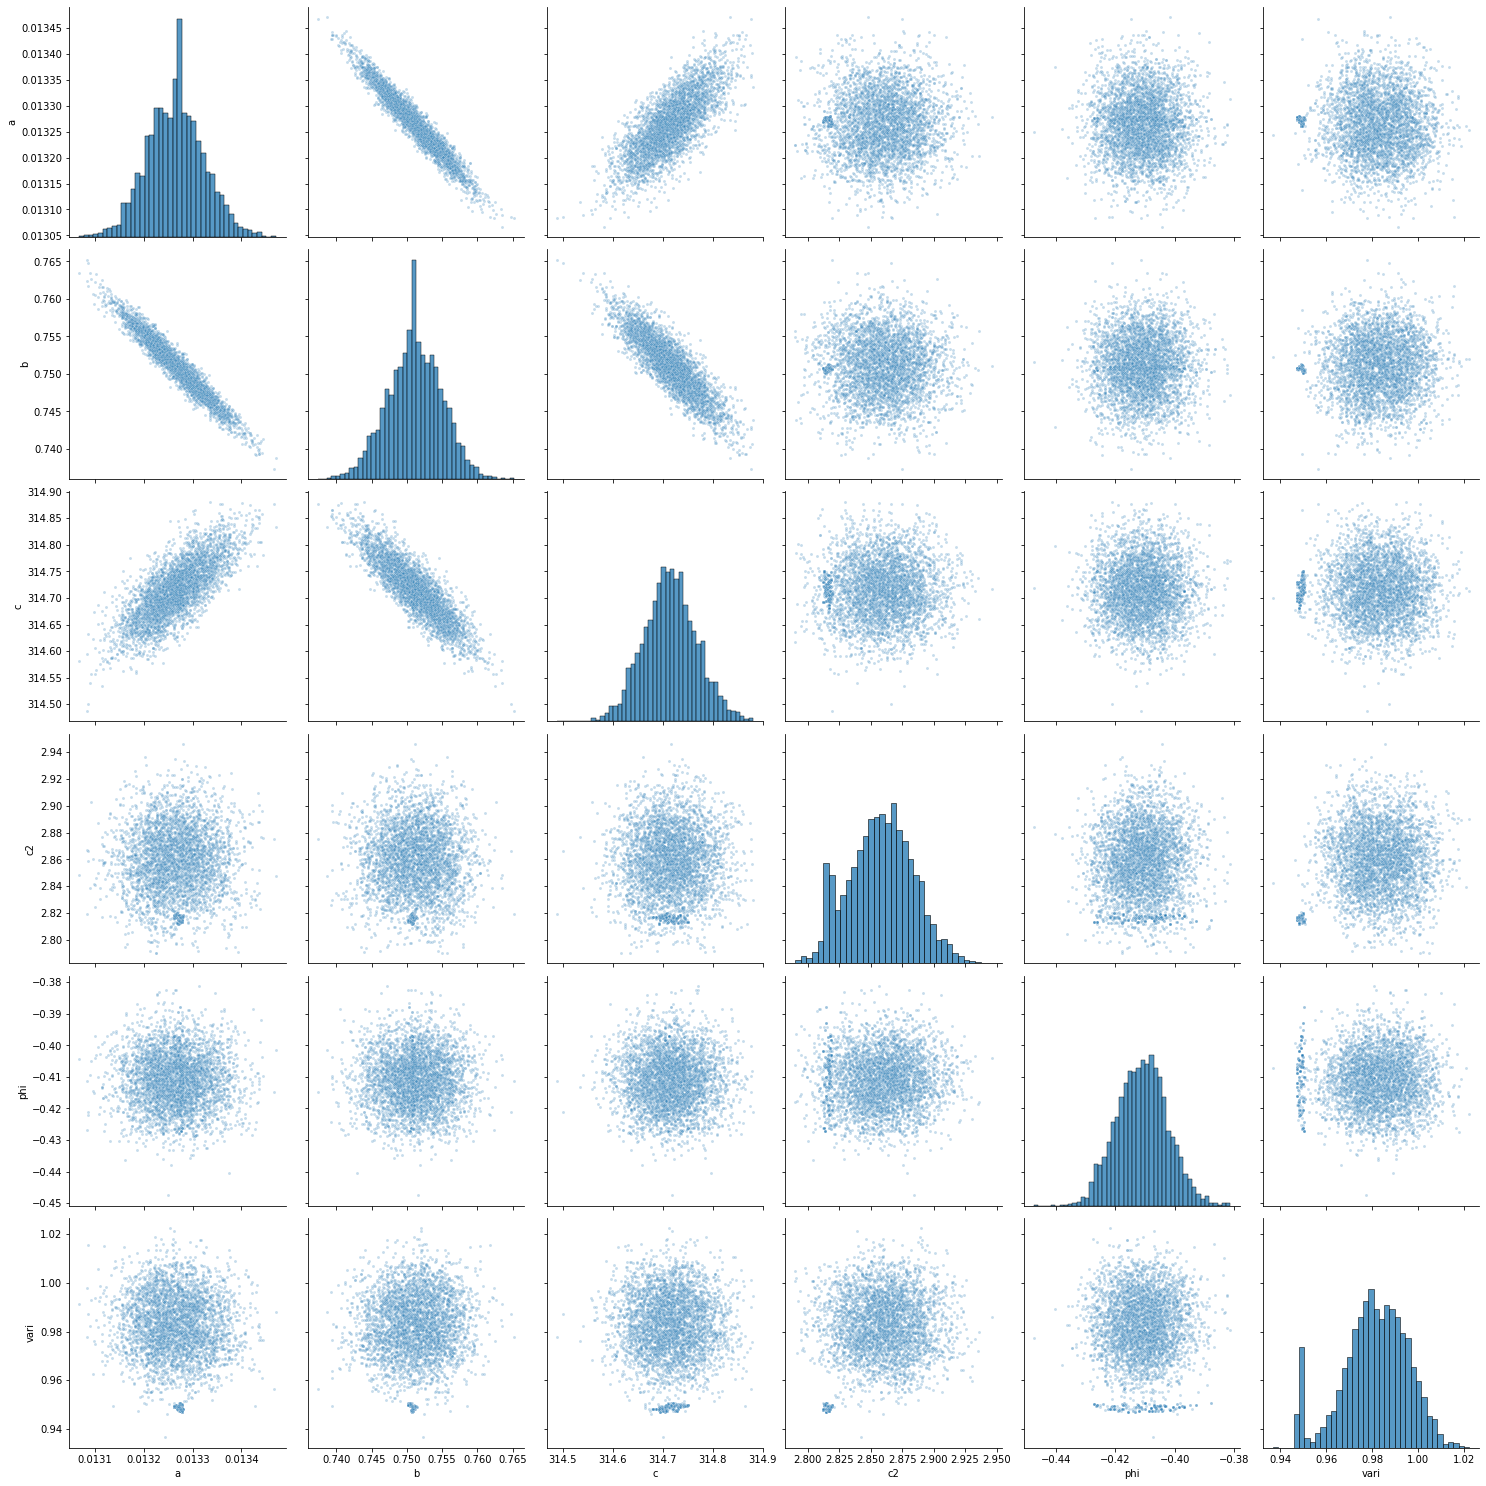

In [132]:
predic_params = ['a','b','c','c2', 'phi','vari']
acf_plots(samples,predic_params)


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


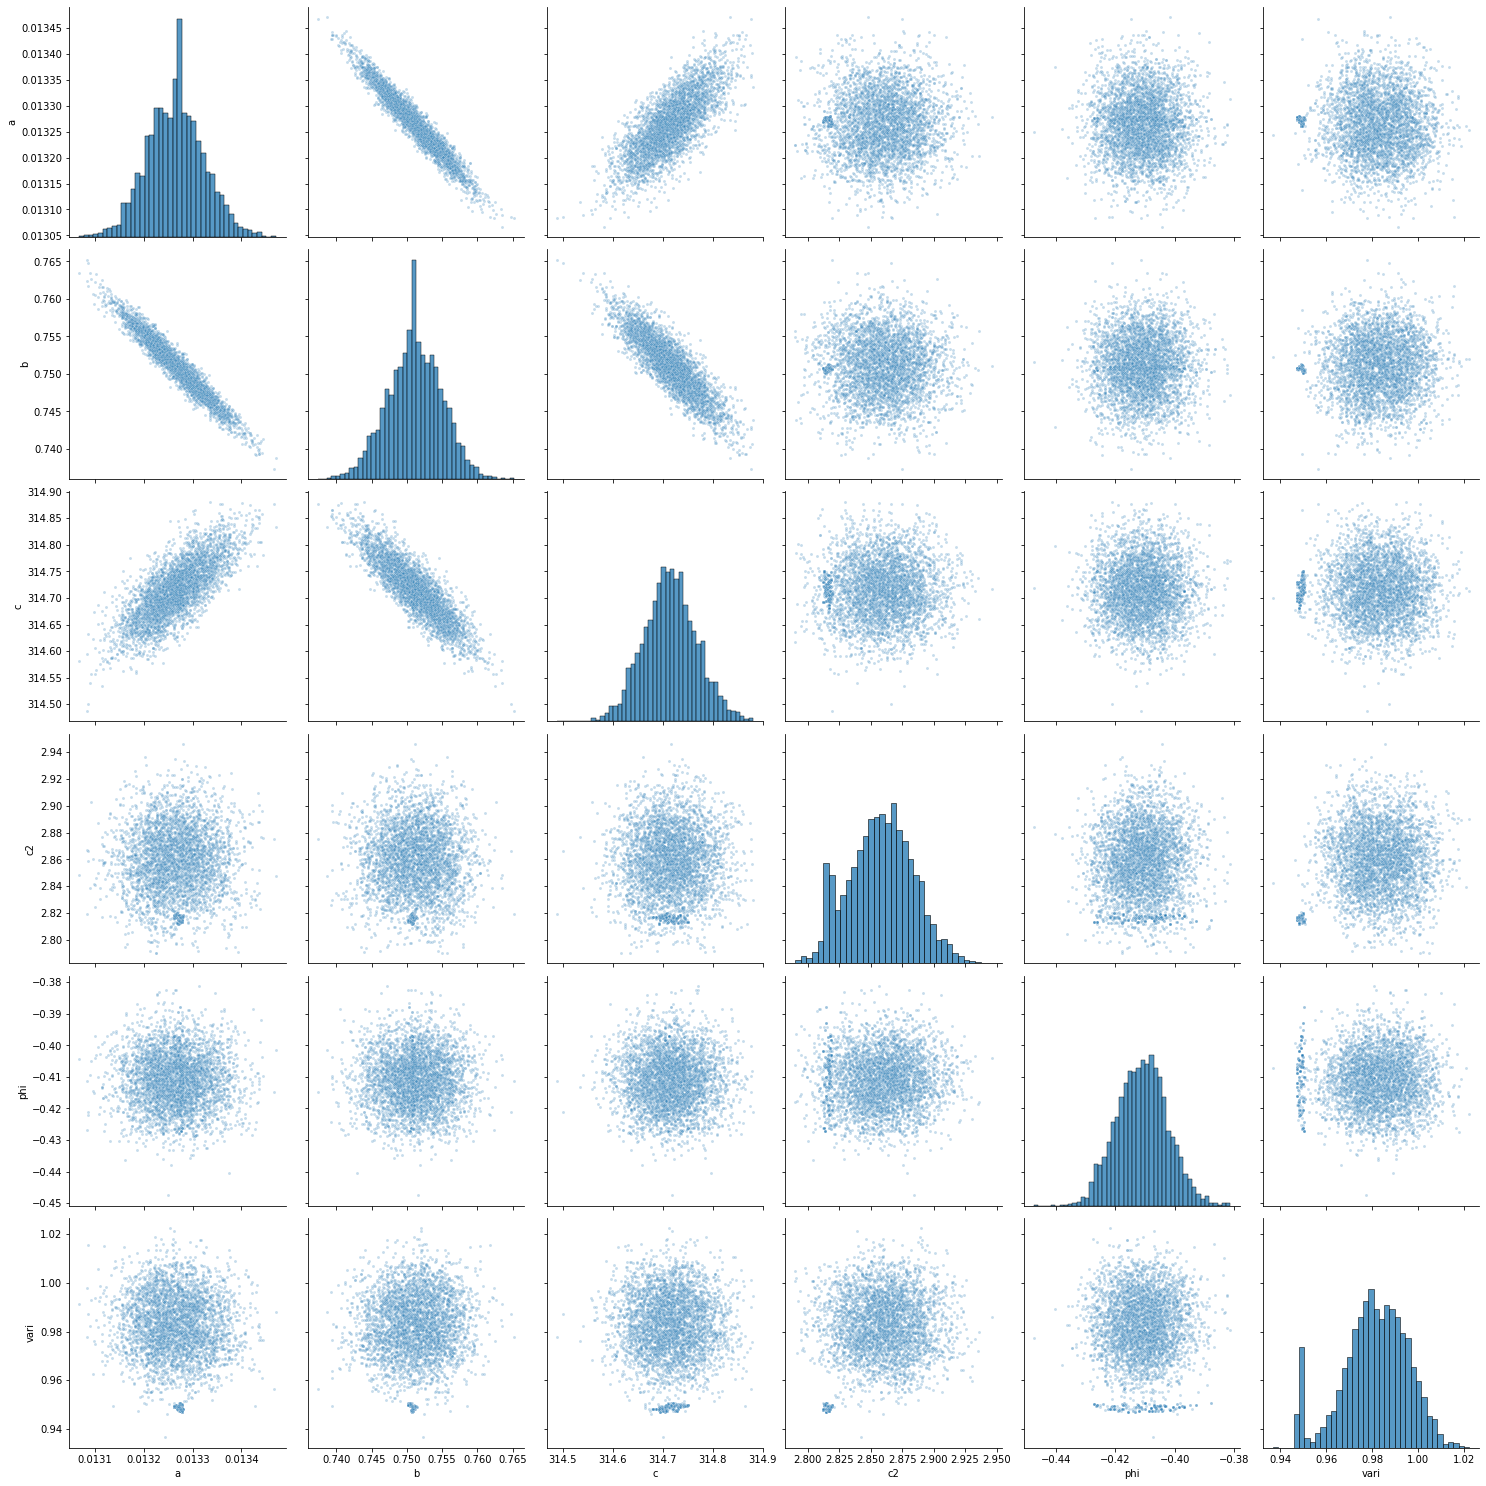

In [133]:
pair_plots(samples, predic_params)

In [151]:
#a*dta.Time_Progression.values**2 + b*dta.Time_Progression.values + c +c2 * np.cos((2 *np.pi *dta.Time_Progression.values)+phi)
store = [ [] for i in range(4000) ]
def create_samples(store, samples):
    
    for i in range(4000):
        
        for t in dta['Time_Progression']:
            store[i].append(sts.norm.rvs(samples['a'][i]*t**2 + samples['b'][i]*t + samples['c'][i] + \
                                 samples['c2'][i]*np.cos(2*np.pi*t + samples['phi'][i])  \
                                 , samples['vari'][i]))
    return store

In [152]:
generated_samples = create_samples(store, samples)

In [153]:
len(generated_samples[0])==len(dta.Date)

True

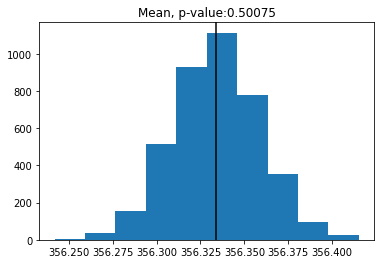

In [159]:
#mean
mean_test = []
count = 0
for i in range(len(generated_samples)):
  mean_test.append(np.mean(generated_samples[i]))
  if np.mean(generated_samples[i]) > np.mean(dta.Amp):
    count += 1
mean_p= count/len(generated_samples)

plt.hist(mean_test)
plt.title('Mean, p-value:'+str(mean_p))
plt.axvline(np.mean(dta.Amp), color='black')

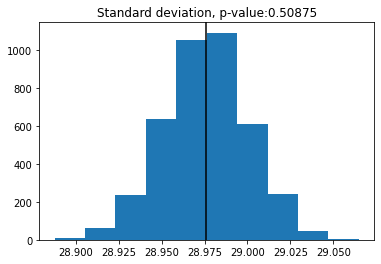

In [158]:
#standard deviation
stand_dev = []
count = 0
for i in range(len(generated_samples)):
  stand_dev.append(np.std(generated_samples[i]))
  if np.std(generated_samples[i]) > np.std(dta.Amp):
    count += 1
sd_p= count/len(generated_samples)

plt.hist(stand_dev)
plt.title('Standard deviation, p-value:'+str(sd_p))
plt.axvline(np.std(dta.Amp), color='black')

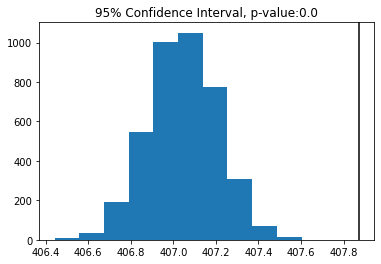

In [160]:
# Confidence Interval
confint_test = []
count = 0
for i in range(len(generated_samples)):
  confint_test.append(np.percentile(generated_samples[i], 95))
  if np.percentile(generated_samples[i], 95) > np.percentile(dta.Amp, 95):
    count += 1
c95_p= count/len(generated_samples)

plt.hist(confint_test)
plt.title('95% Confidence Interval, p-value:'+str(c95_p))
plt.axvline(np.percentile(dta.Amp, 95), color='black')

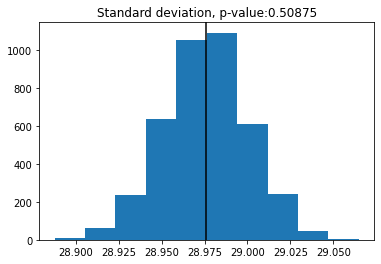